# Training Model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import datetime as dt

import pickle

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import seaborn as sns

/home/team13/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Review the Data and Prep

In [2]:
#read in the cleaned CSV
df = pd.read_csv(f'allTrips_model.csv')

/home/team13/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head(100)

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,HOUR,...,WEATHER_ID,WEATHER_MAIN,WEATHER_DESCRIPTION,RUSHHOUR,JOURNEYTIME,PLAN_JOURNEYTIME,STOP_NUM,LINE_STOP_NUM,AVG_STOP_TIME_MAX,AVG_STOP_TIME
0,2018-01-02,5956084,1,1_40,2,39067,36000,38844.0,36104.0,10.0,...,802,Clouds,scattered clouds,1,2740.0,3067,43,43,63,63
1,2018-01-03,5956084,1,1_40,2,39067,36000,38900.0,36160.0,10.0,...,801,Clouds,few clouds,1,2740.0,3067,43,43,63,63
2,2018-01-04,5956084,1,1_40,2,39067,36000,39244.0,36340.0,10.0,...,500,Rain,light rain,1,2904.0,3067,43,43,67,67
3,2018-01-05,5956084,1,1_40,2,39067,36000,39044.0,36519.0,10.0,...,803,Clouds,broken clouds,1,2525.0,3067,43,43,58,58
4,2018-01-02,5956085,1,1_37,1,43837,40800,43681.0,40862.0,12.0,...,803,Clouds,broken clouds,0,2819.0,3037,42,42,67,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2018-01-05,5959121,1,1_40,2,41467,38400,41839.0,38468.0,11.0,...,803,Clouds,broken clouds,0,3371.0,3067,43,43,78,78
96,2018-01-02,5959122,1,1_37,1,46317,43200,46228.0,43218.0,12.0,...,803,Clouds,broken clouds,0,3010.0,3117,42,42,71,71
97,2018-01-03,5959122,1,1_37,1,46317,43200,46039.0,43234.0,12.0,...,520,Rain,light intensity shower rain,0,2805.0,3117,42,42,66,66
98,2018-01-04,5959122,1,1_37,1,46317,43200,45898.0,43216.0,12.0,...,802,Clouds,scattered clouds,0,2682.0,3117,42,42,63,63


In [4]:
df['LINEID']=df['LINEID'].astype('string')

In [5]:
df['LINEID'].unique()[0:50]

<StringArray>
[  '1', '102', '104',  '11', '111', '114', '116', '118', '120', '122', '123',
  '13', '130',  '14', '140', '142', '145',  '15', '150', '151', '15A', '15B',
 '15D',  '16', '161', '16D',  '17',  '18', '184', '185', '220', '236', '238',
 '239',  '26',  '27', '270', '27A', '27B', '27X',  '32', '32X',  '33', '33D',
 '33E', '33X',  '37',  '38', '38A', '38B']
Length: 50, dtype: string

In [6]:
df['LINEID'].unique()[51:102]

<StringArray>
[ '39', '39A', '39X',   '4',  '40', '40B', '40D', '40E',  '41', '41B', '41C',
 '41D', '41X',  '42',  '43',  '44', '44B', '46A', '46E',  '47',  '49', '51D',
  '53', '54A', '56A',  '59',  '61',  '63',  '65', '65B',  '68', '68A',  '69',
 '69X',   '7',  '70',  '75',  '76', '77A', '77X',  '79', '79A',  '7A',  '7B',
  '7D',  '83', '83A',  '84', '84A', '84X',   '9']
Length: 51, dtype: string

In [7]:
df['LINEID'].nunique()

102

In [8]:
df.columns

Index(['DAYOFSERVICE', 'TRIPID', 'LINEID', 'ROUTEID', 'DIRECTION',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'HOUR', 'MONTH', 'WEEKDAY', 'TEMP', 'VISIBILITY',
       'DEW_POINT', 'FEELS_LIKE', 'HUMIDITY', 'WIND_SPEED', 'RAIN_1H',
       'SNOW_1H', 'CLOUDS_ALL', 'WEATHER_ID', 'WEATHER_MAIN',
       'WEATHER_DESCRIPTION', 'RUSHHOUR', 'JOURNEYTIME', 'PLAN_JOURNEYTIME',
       'STOP_NUM', 'LINE_STOP_NUM', 'AVG_STOP_TIME_MAX', 'AVG_STOP_TIME'],
      dtype='object')

In [9]:
df.shape

(1647986, 31)

In [10]:
df.dtypes

DAYOFSERVICE            object
TRIPID                   int64
LINEID                  string
ROUTEID                 object
DIRECTION                int64
PLANNEDTIME_ARR          int64
PLANNEDTIME_DEP          int64
ACTUALTIME_ARR         float64
ACTUALTIME_DEP         float64
HOUR                   float64
MONTH                    int64
WEEKDAY                  int64
TEMP                   float64
VISIBILITY             float64
DEW_POINT              float64
FEELS_LIKE             float64
HUMIDITY                 int64
WIND_SPEED             float64
RAIN_1H                float64
SNOW_1H                float64
CLOUDS_ALL               int64
WEATHER_ID               int64
WEATHER_MAIN            object
WEATHER_DESCRIPTION     object
RUSHHOUR                 int64
JOURNEYTIME            float64
PLAN_JOURNEYTIME         int64
STOP_NUM                 int64
LINE_STOP_NUM            int64
AVG_STOP_TIME_MAX        int64
AVG_STOP_TIME            int64
dtype: object

In [11]:
#check if there is a null value
df.isna().sum()

DAYOFSERVICE              0
TRIPID                    0
LINEID                    0
ROUTEID                   0
DIRECTION                 0
PLANNEDTIME_ARR           0
PLANNEDTIME_DEP           0
ACTUALTIME_ARR            0
ACTUALTIME_DEP            0
HOUR                      0
MONTH                     0
WEEKDAY                   0
TEMP                      0
VISIBILITY             4889
DEW_POINT                 0
FEELS_LIKE                0
HUMIDITY                  0
WIND_SPEED                0
RAIN_1H                   0
SNOW_1H                   0
CLOUDS_ALL                0
WEATHER_ID                0
WEATHER_MAIN              0
WEATHER_DESCRIPTION       0
RUSHHOUR                  0
JOURNEYTIME               0
PLAN_JOURNEYTIME          0
STOP_NUM                  0
LINE_STOP_NUM             0
AVG_STOP_TIME_MAX         0
AVG_STOP_TIME             0
dtype: int64

In [12]:
df.drop(['DAYOFSERVICE','TRIPID','WEATHER_DESCRIPTION','WEATHER_ID'], inplace=True, axis=1)

In [13]:
df['VISIBILITY'].unique()

array([ 9999., 10000.,  6000.,  7000.,  8000.,  9000.,  5000.,  1500.,
         200.,   100.,   400.,   900.,  4200.,  4500.,  3200.,   500.,
        4000.,   700.,   150.,  3000.,  3500.,  2500.,  2800.,   800.,
        2400.,  1200.,  1800.,   250.,   600.,  1400.,  3800.,  4800.,
        2000.,    nan,  1100.,   300.])

In [14]:
df['WEATHER_MAIN'].unique()

array(['Clouds', 'Rain', 'Drizzle', 'Mist', 'Clear', 'Fog', 'Snow',
       'Thunderstorm', 'Smoke'], dtype=object)

In [15]:
df.shape

(1647986, 27)

In [16]:
df.dtypes

LINEID                string
ROUTEID               object
DIRECTION              int64
PLANNEDTIME_ARR        int64
PLANNEDTIME_DEP        int64
ACTUALTIME_ARR       float64
ACTUALTIME_DEP       float64
HOUR                 float64
MONTH                  int64
WEEKDAY                int64
TEMP                 float64
VISIBILITY           float64
DEW_POINT            float64
FEELS_LIKE           float64
HUMIDITY               int64
WIND_SPEED           float64
RAIN_1H              float64
SNOW_1H              float64
CLOUDS_ALL             int64
WEATHER_MAIN          object
RUSHHOUR               int64
JOURNEYTIME          float64
PLAN_JOURNEYTIME       int64
STOP_NUM               int64
LINE_STOP_NUM          int64
AVG_STOP_TIME_MAX      int64
AVG_STOP_TIME          int64
dtype: object

In [17]:
dropIndex=df[df['AVG_STOP_TIME_MAX']==0].index

In [18]:
df.drop(dropIndex, inplace=True)

### Select the weather information that has the strongest relationship with target feature AVG_STOP_TIME_MAX

In [19]:
df_copy = df

In [20]:
df_copy.shape

(1647977, 27)

In [21]:
df_copy_weather=df_copy.drop(['LINEID','PLANNEDTIME_ARR','PLANNEDTIME_DEP','ACTUALTIME_ARR','ACTUALTIME_DEP','ROUTEID','DIRECTION','HOUR','MONTH','WEEKDAY','RUSHHOUR','JOURNEYTIME','PLAN_JOURNEYTIME','STOP_NUM','LINE_STOP_NUM','AVG_STOP_TIME'],inplace=False, axis=1)


In [22]:
df_copy_weather.columns

Index(['TEMP', 'VISIBILITY', 'DEW_POINT', 'FEELS_LIKE', 'HUMIDITY',
       'WIND_SPEED', 'RAIN_1H', 'SNOW_1H', 'CLOUDS_ALL', 'WEATHER_MAIN',
       'AVG_STOP_TIME_MAX'],
      dtype='object')

In [23]:
df.dtypes

LINEID                string
ROUTEID               object
DIRECTION              int64
PLANNEDTIME_ARR        int64
PLANNEDTIME_DEP        int64
ACTUALTIME_ARR       float64
ACTUALTIME_DEP       float64
HOUR                 float64
MONTH                  int64
WEEKDAY                int64
TEMP                 float64
VISIBILITY           float64
DEW_POINT            float64
FEELS_LIKE           float64
HUMIDITY               int64
WIND_SPEED           float64
RAIN_1H              float64
SNOW_1H              float64
CLOUDS_ALL             int64
WEATHER_MAIN          object
RUSHHOUR               int64
JOURNEYTIME          float64
PLAN_JOURNEYTIME       int64
STOP_NUM               int64
LINE_STOP_NUM          int64
AVG_STOP_TIME_MAX      int64
AVG_STOP_TIME          int64
dtype: object

In [24]:
df_copy_weather.dtypes

TEMP                 float64
VISIBILITY           float64
DEW_POINT            float64
FEELS_LIKE           float64
HUMIDITY               int64
WIND_SPEED           float64
RAIN_1H              float64
SNOW_1H              float64
CLOUDS_ALL             int64
WEATHER_MAIN          object
AVG_STOP_TIME_MAX      int64
dtype: object

In [25]:
continuous_columns_weather = df[['TEMP','VISIBILITY','DEW_POINT','FEELS_LIKE','HUMIDITY','WIND_SPEED','RAIN_1H','SNOW_1H','CLOUDS_ALL']].columns

In [26]:
y = pd.DataFrame(df_copy_weather['AVG_STOP_TIME_MAX'])
X = df_copy_weather.drop(['AVG_STOP_TIME_MAX','WEATHER_MAIN'],1)

In [27]:
X.dtypes

TEMP          float64
VISIBILITY    float64
DEW_POINT     float64
FEELS_LIKE    float64
HUMIDITY        int64
WIND_SPEED    float64
RAIN_1H       float64
SNOW_1H       float64
CLOUDS_ALL      int64
dtype: object

####  Plot the correlations between all weather features 

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'TEMP'),
  Text(1.5, 0, 'VISIBILITY'),
  Text(2.5, 0, 'DEW_POINT'),
  Text(3.5, 0, 'FEELS_LIKE'),
  Text(4.5, 0, 'HUMIDITY'),
  Text(5.5, 0, 'WIND_SPEED'),
  Text(6.5, 0, 'RAIN_1H'),
  Text(7.5, 0, 'SNOW_1H'),
  Text(8.5, 0, 'CLOUDS_ALL')])

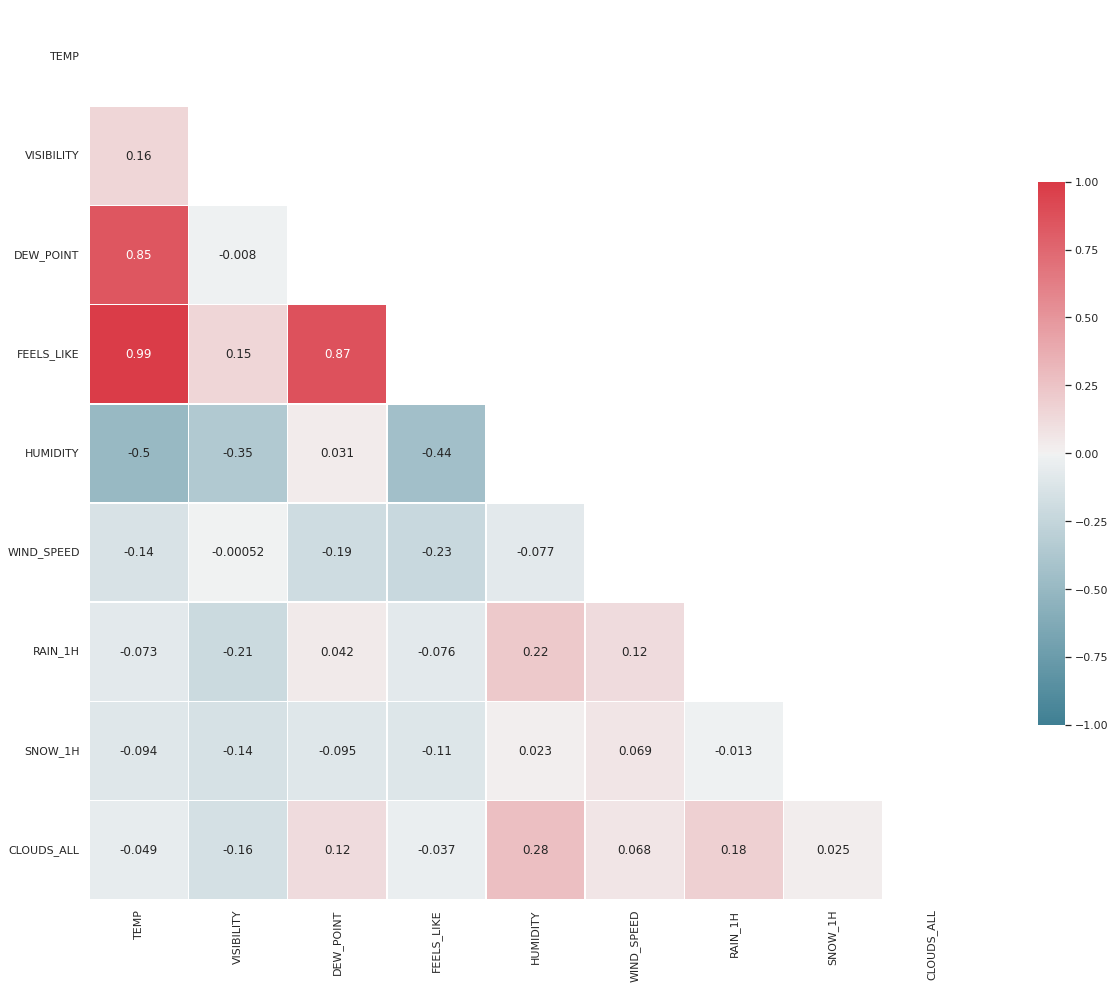

In [28]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = X[continuous_columns_weather].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

#### Plot the interaction between continuous weather features and target features

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,AVG_STOP_TIME_MAX
WIND_SPEED,0.063220
TEMP,0.038468
FEELS_LIKE,0.031047
CLOUDS_ALL,0.024791
RAIN_1H,0.021819
VISIBILITY,0.007642
DEW_POINT,-0.018538
SNOW_1H,-0.023281
HUMIDITY,-0.105259


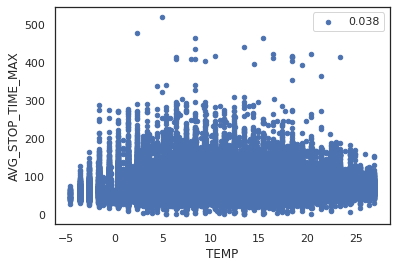

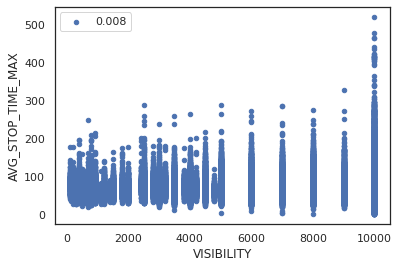

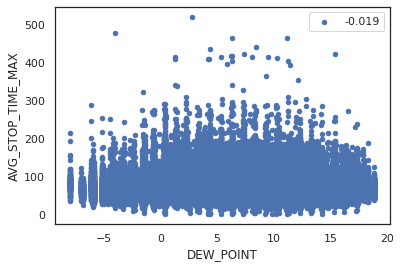

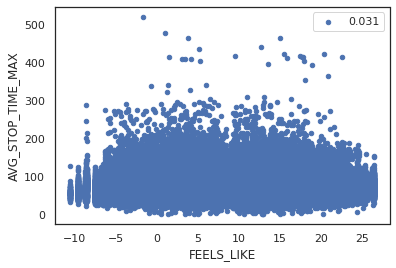

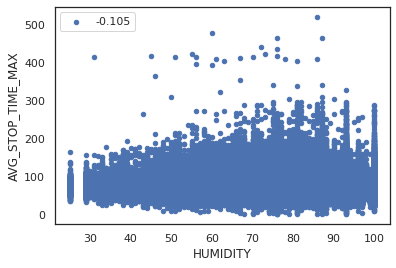

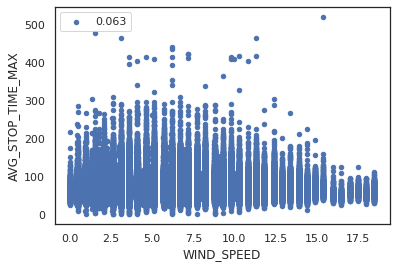

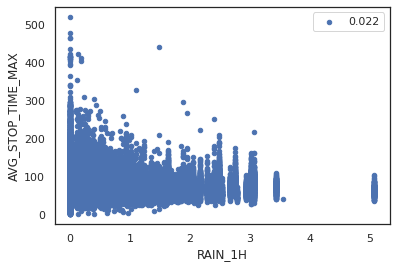

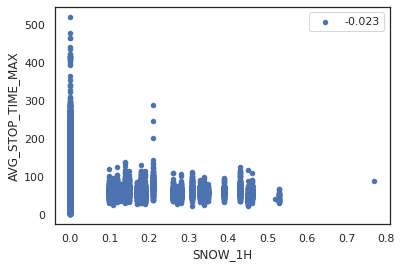

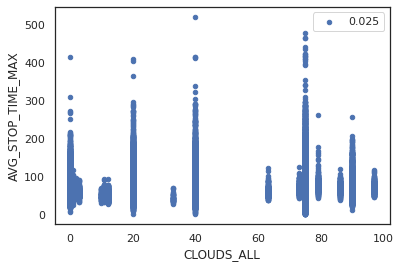

In [29]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X[continuous_columns_weather]:
    # create temp df to merge column and target
    df_temp = pd.concat([X[column], y], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "AVG_STOP_TIME_MAX"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="AVG_STOP_TIME_MAX", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['AVG_STOP_TIME_MAX']).sort_values('AVG_STOP_TIME_MAX', ascending=False)
corr_df

We can keep WIND_SPEED HUMIDITY columns.

### Select the category features that has the strongest relationship with target feature AVG_STOP_TIME_MAX

In [30]:
category_columns = df[['HOUR','MONTH','WEEKDAY','RUSHHOUR']].columns

In [31]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in category_columns:
    # create temp df to merge column and target
    df_temp = pd.concat([df[column], df['AVG_STOP_TIME_MAX']], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "AVG_STOP_TIME_MAX"]].corr().values[0,1]
    # plot the column and tartget feature
    # add correlation to dic
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['AVG_STOP_TIME_MAX']).sort_values('AVG_STOP_TIME_MAX', ascending=False)
corr_df

,AVG_STOP_TIME_MAX
RUSHHOUR,0.279698
MONTH,0.042747
WEEKDAY,-0.110498
HOUR,-0.153834


<AxesSubplot:xlabel='HOUR', ylabel='AVG_STOP_TIME_MAX'>

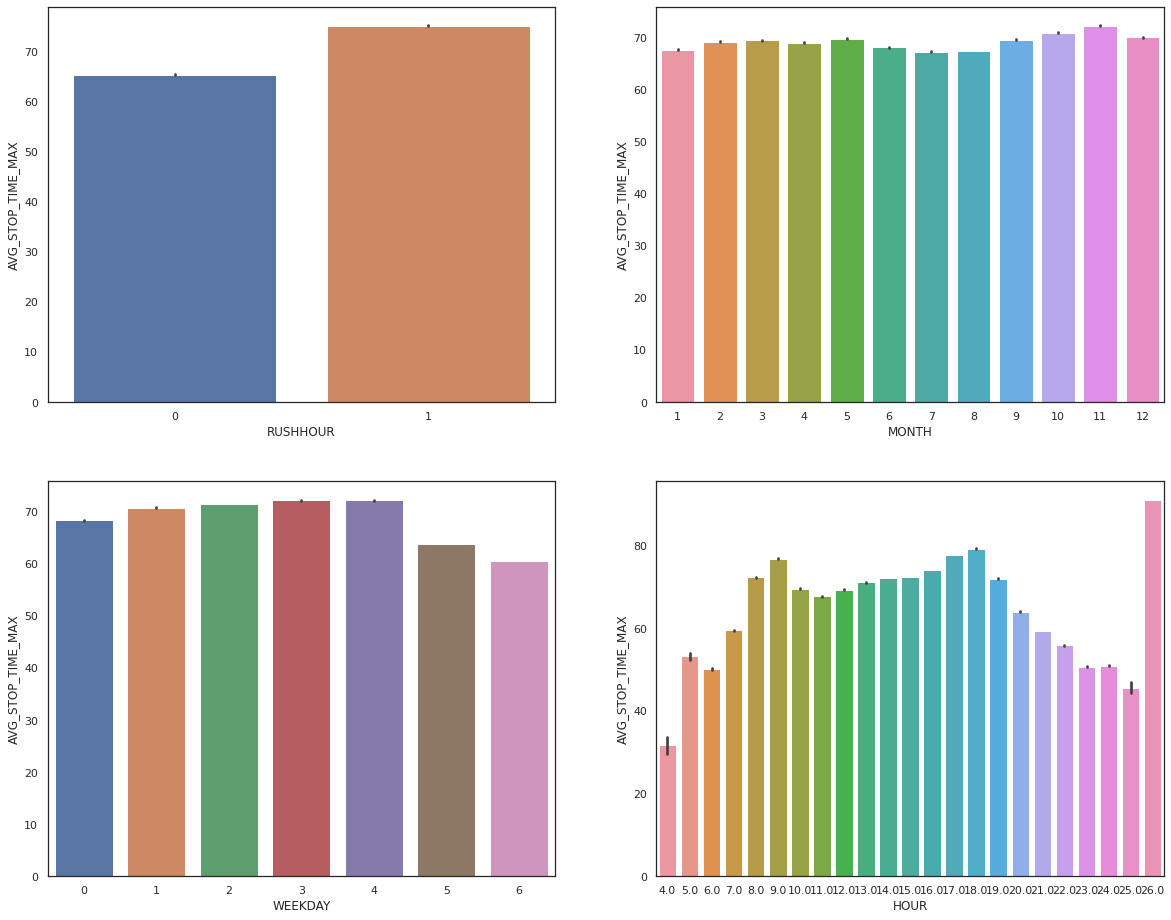

In [32]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,16))
axes[0][0].set(xlabel='RUSHHOUR', ylabel='AVG_STOP_TIME_MAX')
axes[0][1].set(xlabel='MONTH', ylabel='AVG_STOP_TIME_MAX')
axes[1][0].set(xlabel='WEEKDAY', ylabel='AVG_STOP_TIME_MAX')
axes[1][1].set(xlabel='HOUR', ylabel='AVG_STOP_TIME_MAX')
sns.barplot(data=df, y='AVG_STOP_TIME_MAX',x="RUSHHOUR",orient="v",ax=axes[0][0])
sns.barplot(data=df, y='AVG_STOP_TIME_MAX',x="MONTH",orient="v",ax=axes[0][1])
sns.barplot(data=df, y='AVG_STOP_TIME_MAX',x="WEEKDAY",orient="v",ax=axes[1][0])
sns.barplot(data=df, y='AVG_STOP_TIME_MAX',x="HOUR",orient="v",ax=axes[1][1])

We can keep RUSHHOUR WEEKDAY HOUR  columns.

#### drop the columns that we don't need

In [33]:
df.drop(['TEMP','VISIBILITY','DEW_POINT','FEELS_LIKE','RAIN_1H','SNOW_1H','CLOUDS_ALL','MONTH','WEATHER_MAIN'],inplace=True, axis=1)

In [34]:
df.dtypes

LINEID                string
ROUTEID               object
DIRECTION              int64
PLANNEDTIME_ARR        int64
PLANNEDTIME_DEP        int64
ACTUALTIME_ARR       float64
ACTUALTIME_DEP       float64
HOUR                 float64
WEEKDAY                int64
HUMIDITY               int64
WIND_SPEED           float64
RUSHHOUR               int64
JOURNEYTIME          float64
PLAN_JOURNEYTIME       int64
STOP_NUM               int64
LINE_STOP_NUM          int64
AVG_STOP_TIME_MAX      int64
AVG_STOP_TIME          int64
dtype: object

In [35]:
df.drop(['ROUTEID'], axis=1, inplace=True)


Cannot get the relevant input-output so drop it

In [36]:
df.drop(['JOURNEYTIME','PLAN_JOURNEYTIME','STOP_NUM','ACTUALTIME_DEP','LINE_STOP_NUM','AVG_STOP_TIME','PLANNEDTIME_ARR','PLANNEDTIME_DEP','ACTUALTIME_ARR'], axis=1, inplace=True)


The above fields are logically related to the target feature and will affect the prediction, so delete

In [37]:
df_lgbm=df

## Set Up the Columns Types in a Proper Way

In [38]:
df.tail(5)

,LINEID,DIRECTION,HOUR,WEEKDAY,HUMIDITY,WIND_SPEED,RUSHHOUR,AVG_STOP_TIME_MAX
1647981,9,2,18.0,2,86,4.60,1,53
1647982,9,2,18.0,6,85,1.34,1,64
1647983,9,1,20.0,6,94,2.60,0,72
1647984,9,1,20.0,2,83,3.10,0,58
1647985,9,1,20.0,6,87,0.45,0,54


In [39]:
df1 = pd.get_dummies(df['HOUR'])

In [40]:
df = pd.concat([df, df1], axis=1)

In [41]:
df

,LINEID,DIRECTION,HOUR,WEEKDAY,HUMIDITY,WIND_SPEED,RUSHHOUR,AVG_STOP_TIME_MAX,4.0,5.0,...,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0
0,1,2,10.0,1,87,10.80,1,63,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,10.0,2,76,12.40,1,63,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,10.0,3,87,7.20,1,67,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,10.0,4,86,4.60,1,58,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,12.0,1,76,12.40,0,67,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647981,9,2,18.0,2,86,4.60,1,53,0,0,...,0,1,0,0,0,0,0,0,0,0
1647982,9,2,18.0,6,85,1.34,1,64,0,0,...,0,1,0,0,0,0,0,0,0,0
1647983,9,1,20.0,6,94,2.60,0,72,0,0,...,0,0,0,1,0,0,0,0,0,0
1647984,9,1,20.0,2,83,3.10,0,58,0,0,...,0,0,0,1,0,0,0,0,0,0


In [42]:
df.drop('HOUR', axis=1, inplace=True)

In [43]:
df.dtypes

LINEID                string
DIRECTION              int64
WEEKDAY                int64
HUMIDITY               int64
WIND_SPEED           float64
RUSHHOUR               int64
AVG_STOP_TIME_MAX      int64
4.0                    uint8
5.0                    uint8
6.0                    uint8
7.0                    uint8
8.0                    uint8
9.0                    uint8
10.0                   uint8
11.0                   uint8
12.0                   uint8
13.0                   uint8
14.0                   uint8
15.0                   uint8
16.0                   uint8
17.0                   uint8
18.0                   uint8
19.0                   uint8
20.0                   uint8
21.0                   uint8
22.0                   uint8
23.0                   uint8
24.0                   uint8
25.0                   uint8
26.0                   uint8
dtype: object

In [44]:
df.head(10)

,LINEID,DIRECTION,WEEKDAY,HUMIDITY,WIND_SPEED,RUSHHOUR,AVG_STOP_TIME_MAX,4.0,5.0,6.0,...,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0
0,1,2,1,87,10.8,1,63,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,2,76,12.4,1,63,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,3,87,7.2,1,67,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,4,86,4.6,1,58,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,76,12.4,0,67,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1,2,81,11.8,0,69,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,1,3,86,15.4,0,59,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,1,4,86,3.6,0,68,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,2,1,76,10.8,0,84,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,2,2,75,13.4,0,73,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df2 = pd.get_dummies(df['WEEKDAY'])

In [46]:
df = pd.concat([df, df2], axis=1)

In [47]:
df.drop('WEEKDAY', axis=1, inplace=True)

In [48]:
df.dtypes

LINEID                string
DIRECTION              int64
HUMIDITY               int64
WIND_SPEED           float64
RUSHHOUR               int64
AVG_STOP_TIME_MAX      int64
4.0                    uint8
5.0                    uint8
6.0                    uint8
7.0                    uint8
8.0                    uint8
9.0                    uint8
10.0                   uint8
11.0                   uint8
12.0                   uint8
13.0                   uint8
14.0                   uint8
15.0                   uint8
16.0                   uint8
17.0                   uint8
18.0                   uint8
19.0                   uint8
20.0                   uint8
21.0                   uint8
22.0                   uint8
23.0                   uint8
24.0                   uint8
25.0                   uint8
26.0                   uint8
0                      uint8
1                      uint8
2                      uint8
3                      uint8
4                      uint8
5             

In [49]:
#df3 = pd.get_dummies(df['WEATHER_MAIN'])

In [50]:
#df = pd.concat([df, df3], axis=1)

In [51]:
#df.head(3)

In [52]:
#df.drop('WEATHER_MAIN', axis=1, inplace=True)

In [53]:
#df.head(3)

In [54]:
df4 = pd.get_dummies(df['RUSHHOUR'])

In [55]:
df = pd.concat([df, df4], axis=1)

In [56]:
df.head(3)

,LINEID,DIRECTION,HUMIDITY,WIND_SPEED,RUSHHOUR,AVG_STOP_TIME_MAX,4.0,5.0,6.0,7.0,...,26.0,0,1,2,3,4,5,6,0,1
0,1,2,87,10.8,1,63,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,2,76,12.4,1,63,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1,2,87,7.2,1,67,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [57]:
df.drop('RUSHHOUR', axis=1, inplace=True)

In [58]:
df.head(3)

,LINEID,DIRECTION,HUMIDITY,WIND_SPEED,AVG_STOP_TIME_MAX,4.0,5.0,6.0,7.0,8.0,...,26.0,0,1,2,3,4,5,6,0,1
0,1,2,87,10.8,63,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,2,76,12.4,63,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1,2,87,7.2,67,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [59]:
df.dtypes

LINEID                string
DIRECTION              int64
HUMIDITY               int64
WIND_SPEED           float64
AVG_STOP_TIME_MAX      int64
4.0                    uint8
5.0                    uint8
6.0                    uint8
7.0                    uint8
8.0                    uint8
9.0                    uint8
10.0                   uint8
11.0                   uint8
12.0                   uint8
13.0                   uint8
14.0                   uint8
15.0                   uint8
16.0                   uint8
17.0                   uint8
18.0                   uint8
19.0                   uint8
20.0                   uint8
21.0                   uint8
22.0                   uint8
23.0                   uint8
24.0                   uint8
25.0                   uint8
26.0                   uint8
0                      uint8
1                      uint8
2                      uint8
3                      uint8
4                      uint8
5                      uint8
6             

In [60]:
df.head(5)

,LINEID,DIRECTION,HUMIDITY,WIND_SPEED,AVG_STOP_TIME_MAX,4.0,5.0,6.0,7.0,8.0,...,26.0,0,1,2,3,4,5,6,0,1
0,1,2,87,10.8,63,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,2,76,12.4,63,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1,2,87,7.2,67,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,1,2,86,4.6,58,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,1,1,76,12.4,67,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [61]:
df.dtypes

LINEID                string
DIRECTION              int64
HUMIDITY               int64
WIND_SPEED           float64
AVG_STOP_TIME_MAX      int64
4.0                    uint8
5.0                    uint8
6.0                    uint8
7.0                    uint8
8.0                    uint8
9.0                    uint8
10.0                   uint8
11.0                   uint8
12.0                   uint8
13.0                   uint8
14.0                   uint8
15.0                   uint8
16.0                   uint8
17.0                   uint8
18.0                   uint8
19.0                   uint8
20.0                   uint8
21.0                   uint8
22.0                   uint8
23.0                   uint8
24.0                   uint8
25.0                   uint8
26.0                   uint8
0                      uint8
1                      uint8
2                      uint8
3                      uint8
4                      uint8
5                      uint8
6             

## split the dataset by directions

In [62]:
df_direction_1 = df[df['DIRECTION']==1]

In [63]:
df_direction_1.shape

(823582, 37)

In [64]:
df_direction_1.dtypes

LINEID                string
DIRECTION              int64
HUMIDITY               int64
WIND_SPEED           float64
AVG_STOP_TIME_MAX      int64
4.0                    uint8
5.0                    uint8
6.0                    uint8
7.0                    uint8
8.0                    uint8
9.0                    uint8
10.0                   uint8
11.0                   uint8
12.0                   uint8
13.0                   uint8
14.0                   uint8
15.0                   uint8
16.0                   uint8
17.0                   uint8
18.0                   uint8
19.0                   uint8
20.0                   uint8
21.0                   uint8
22.0                   uint8
23.0                   uint8
24.0                   uint8
25.0                   uint8
26.0                   uint8
0                      uint8
1                      uint8
2                      uint8
3                      uint8
4                      uint8
5                      uint8
6             

In [65]:
df_copy

,LINEID,DIRECTION,HOUR,WEEKDAY,HUMIDITY,WIND_SPEED,RUSHHOUR,AVG_STOP_TIME_MAX
0,1,2,10.0,1,87,10.80,1,63
1,1,2,10.0,2,76,12.40,1,63
2,1,2,10.0,3,87,7.20,1,67
3,1,2,10.0,4,86,4.60,1,58
4,1,1,12.0,1,76,12.40,0,67
...,...,...,...,...,...,...,...,...
1647981,9,2,18.0,2,86,4.60,1,53
1647982,9,2,18.0,6,85,1.34,1,64
1647983,9,1,20.0,6,94,2.60,0,72
1647984,9,1,20.0,2,83,3.10,0,58


In [66]:
lines=[]
lines=df_direction_1['LINEID'].unique()

In [67]:
lines

<StringArray>
[  '1', '102', '104',  '11', '111', '114', '116', '120', '122', '123',  '13',
 '130',  '14', '140', '142', '145',  '15', '150', '151', '15A', '15B', '15D',
  '16', '161', '16D',  '17',  '18', '184', '185', '220', '236', '238', '239',
  '26',  '27', '270', '27A', '27B', '27X',  '32', '32X',  '33', '33D', '33E',
 '33X',  '37',  '38', '38A', '38B', '38D',  '39', '39A', '39X',   '4',  '40',
 '40B', '40D', '40E',  '41', '41B', '41C', '41D', '41X',  '42',  '43',  '44',
 '44B', '46A',  '47',  '49', '51D',  '53', '54A', '56A',  '59',  '61',  '63',
  '65', '65B',  '68', '68A',  '69', '69X',   '7',  '70',  '75',  '76', '77A',
  '79', '79A',  '7A',  '7B',  '7D',  '83', '83A',  '84', '84A', '84X',   '9']
Length: 99, dtype: string

In [68]:
 workingDF_test = df_direction_1[(df_direction_1['LINEID']=='39A')]

# Split the two 

In [69]:
X_trainDict_1 = {}
y_trainDict_1 = {}
X_testDict_1 ={}
y_testDict_1 = {}
remove = []

for line in lines:
    print(f'Now modelling stop number {line}')
    #生成方向为1的数据集
    workingDF = df_direction_1[(df_direction_1['LINEID']==line)]
    #如果一个站的次数为1次或者2次，就放到remove里面
    if workingDF.shape[0] < 3:
        print(f'{line}too small')
        remove.append(line)
        continue
    
    #删除一些没有必要的列
    workingDF.drop(columns=['LINEID',  'DIRECTION'], inplace=True)

    
    # 定义目标特征
    y = workingDF["AVG_STOP_TIME_MAX"]
    # 删除目标特征
    X = workingDF.drop(["AVG_STOP_TIME_MAX"],1)
    # Split the dataset into two datasets: 70% training and 30% test
    
    #划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,  test_size=0.3)
    #将数据存到字典当中
    X_trainDict_1[f'{line}'] = X_train
    X_testDict_1[f'{line}'] = X_test
    y_trainDict_1[f'{line}'] = y_train
    y_testDict_1[f'{line}'] = y_test
    
    # 重新设置index
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
#删除一些不常用的站
    
    
for i in remove:
    lines.remove(i)

Now modelling stop number 1
Now modelling stop number 102


/home/team13/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Now modelling stop number 104
Now modelling stop number 11
Now modelling stop number 111
Now modelling stop number 114
Now modelling stop number 116
Now modelling stop number 120
Now modelling stop number 122
Now modelling stop number 123
Now modelling stop number 13
Now modelling stop number 130
Now modelling stop number 14
Now modelling stop number 140
Now modelling stop number 142
Now modelling stop number 145
Now modelling stop number 15
Now modelling stop number 150
Now modelling stop number 151
Now modelling stop number 15A
Now modelling stop number 15B
Now modelling stop number 15D
Now modelling stop number 16
Now modelling stop number 161
Now modelling stop number 16D
Now modelling stop number 17
Now modelling stop number 18
Now modelling stop number 184
Now modelling stop number 185
Now modelling stop number 220
Now modelling stop number 236
Now modelling stop number 238
Now modelling stop number 239
Now modelling stop number 26
Now modelling stop number 27
Now modelling stop 

### Evaluation metrics

In [70]:
def cross_val__DF(ActualVal,predictions,typef):
    results = {}
    mae=metrics.mean_absolute_error(ActualVal, predictions)
    mse =metrics.mean_squared_error(ActualVal, predictions)
    rmse = mse**0.5
    mape = np.mean(np.abs((ActualVal - predictions)/ActualVal))*100
    r2 = metrics.r2_score(ActualVal, predictions)
    results['MAE'] = mae
    results['MSE'] = mse
    results['RMSE'] = rmse
    results['MAPE'] = mape
    results['R2'] = r2
    regDF = pd.DataFrame.from_dict(results, orient='index', columns=[typef])
    
    return regDF.T
    
    

In [71]:
def cross_val__DF_AVG(maeList,mseList,rmseList,mapeList,r2List,typef):
    #Average metrics for the all lines
    results = {}
    
    results['MAE'] = sum(maeList)/len(maeList)
    results['MSE'] = sum(mseList)/len(mseList)
    results['RMSE'] = sum(rmseList)/len(rmseList)
    results['MAPE'] = sum(mapeList)/len(mapeList)
    results['R2'] = sum(r2List)/len(r2List)
    regDF = pd.DataFrame.from_dict(results, orient='index', columns=[typef])
    
    return regDF.T
    

## Model training

## LinearRegression

In [72]:
maeList_train_li=[]
mseList_train_li=[]
rmseList_train_li=[]
mapeList_train_li=[]
r2List_train_li=[]
print('Evaluation of the train dataset')
for line in lines:
    print(f'Now modelling line number {line}.')
    
    X_train = X_trainDict_1[f'{line}']
    X_test = X_testDict_1[f'{line}']
    y_train = y_trainDict_1[f'{line}']
    y_test = y_testDict_1[f'{line}']
    
    linReg=LinearRegression().fit(X_train, y_train)
    #Building the Linear Regression Model
    y_train_predict=linReg.predict(X_train)
#     with open('lines/model_'+str(line)+'_1'+'.pkl','wb') as handle:
#         pickle.dump(linReg, handle, pickle.HIGHEST_PROTOCOL)
    regDF=cross_val__DF(y_train,y_train_predict,'LinearRegression')
    print(regDF)
    maeList_train_li.append(regDF['MAE'])
    mseList_train_li.append(regDF['MSE'])
    rmseList_train_li.append(regDF['RMSE'])
    mapeList_train_li.append(regDF['MAPE'])
    r2List_train_li.append(regDF['R2'])


    print('==========================================================================')

Evaluation of the train dataset
Now modelling line number 1.
                       MAE       MSE      RMSE       MAPE       R2
LinearRegression  7.190888  90.68986  9.523122  10.537342  0.48707
Now modelling line number 102.
                       MAE        MSE     RMSE      MAPE       R2
LinearRegression  5.943178  61.939578  7.87017  8.880547  0.35173
Now modelling line number 104.
                       MAE        MSE       RMSE       MAPE        R2
LinearRegression  7.578261  111.21451  10.545829  11.198756  0.329334
Now modelling line number 11.
                        MAE         MSE       RMSE       MAPE        R2
LinearRegression  11.004311  191.927649  13.853795  14.647797  0.506386
Now modelling line number 111.
                       MAE        MSE     RMSE      MAPE        R2
LinearRegression  4.731797  43.258903  6.57715  8.535778  0.604831
Now modelling line number 114.
                       MAE        MSE       RMSE       MAPE       R2
LinearRegression  7.968415  120.

                       MAE        MSE      RMSE      MAPE        R2
LinearRegression  5.675774  53.068142  7.284788  9.050103  0.602265
Now modelling line number 270.
                        MAE         MSE       RMSE       MAPE       R2
LinearRegression  12.244339  320.972204  17.915697  15.084389  0.24267
Now modelling line number 27A.
                       MAE        MSE      RMSE      MAPE        R2
LinearRegression  4.644679  38.137273  6.175538  9.851412  0.615641
Now modelling line number 27B.
                       MAE       MSE      RMSE       MAPE      R2
LinearRegression  6.093268  67.94645  8.242964  10.571306  0.4666
Now modelling line number 27X.
                       MAE       MSE      RMSE      MAPE        R2
LinearRegression  7.220952  90.60893  9.518872  7.948023  0.327094
Now modelling line number 32.
                      MAE       MSE      RMSE      MAPE        R2
LinearRegression  4.85428  41.16837  6.416258  9.312316  0.568252
Now modelling line number 32X.
   

                       MAE         MSE       RMSE       MAPE        R2
LinearRegression  7.518981  104.063623  10.201158  10.170655  0.599303
Now modelling line number 51D.
                       MAE        MSE      RMSE      MAPE        R2
LinearRegression  4.733757  39.759918  6.305547  6.016048  0.196588
Now modelling line number 53.
                        MAE          MSE       RMSE       MAPE        R2
LinearRegression  24.832441  1075.722541  32.798209  28.183049  0.184001
Now modelling line number 54A.
                       MAE         MSE       RMSE       MAPE        R2
LinearRegression  7.181363  105.797207  10.285777  10.574734  0.472905
Now modelling line number 56A.
                      MAE        MSE      RMSE      MAPE        R2
LinearRegression  5.52115  55.139187  7.425577  9.257378  0.647036
Now modelling line number 59.
                      MAE        MSE     RMSE      MAPE        R2
LinearRegression  4.72381  48.497158  6.96399  9.733651  0.378041
Now modelling l

In [73]:
regDF_LINE_TRAIN_AVG=cross_val__DF_AVG(maeList_train_li,mseList_train_li,rmseList_train_li,mapeList_train_li,r2List_train_li,'LinearRegression')


In [74]:
regDF_LINE_TRAIN_AVG

,MAE,MAPE,MSE,R2,RMSE
LinearRegression,7.218158,10.031196,108.645031,0.459395,9.669997


In [75]:
maeList_li=[]
mseList_li=[]
rmseList_li=[]
mapeList_li=[]
r2List_li=[]
print('Evaluation of the test dataset')
for line in lines:
    print(f'Now modelling line number {line}.')
    
    X_train = X_trainDict_1[f'{line}']
    X_test = X_testDict_1[f'{line}']
    y_train = y_trainDict_1[f'{line}']
    y_test = y_testDict_1[f'{line}']
    
    linReg=LinearRegression().fit(X_train, y_train)
    #Building the Linear Regression Model
    y_test_predict=linReg.predict(X_test)
#     with open('lines/model_'+str(line)+'_1'+'.pkl','wb') as handle:
#         pickle.dump(linReg, handle, pickle.HIGHEST_PROTOCOL)
    regDF=cross_val__DF(y_test,y_test_predict,'LinearRegression')
    print(regDF)
    maeList_li.append(regDF['MAE'])
    mseList_li.append(regDF['MSE'])
    rmseList_li.append(regDF['RMSE'])
    mapeList_li.append(regDF['MAPE'])
    r2List_li.append(regDF['R2'])


    print('==========================================================================')

Evaluation of the test dataset
Now modelling line number 1.
                       MAE       MSE      RMSE       MAPE        R2
LinearRegression  7.284065  95.95836  9.795834  10.577078  0.462759
Now modelling line number 102.
                       MAE        MSE     RMSE      MAPE       R2
LinearRegression  6.138445  66.794503  8.17279  9.222198  0.33576
Now modelling line number 104.
                       MAE        MSE       RMSE       MAPE        R2
LinearRegression  7.460135  113.14602  10.637012  10.921052  0.317401
Now modelling line number 11.
                        MAE         MSE       RMSE       MAPE        R2
LinearRegression  11.165791  195.407381  13.978819  14.728058  0.510991
Now modelling line number 111.
                       MAE        MSE      RMSE     MAPE        R2
LinearRegression  4.799362  47.876906  6.919314  8.50645  0.575514
Now modelling line number 114.
                       MAE         MSE       RMSE       MAPE        R2
LinearRegression  7.935867  1

                       MAE        MSE      RMSE      MAPE        R2
LinearRegression  5.705747  53.743576  7.331001  9.024542  0.598595
Now modelling line number 270.
                        MAE         MSE       RMSE       MAPE        R2
LinearRegression  12.409098  353.445913  18.800157  15.008082  0.229961
Now modelling line number 27A.
                       MAE       MSE      RMSE      MAPE       R2
LinearRegression  4.589283  36.33352  6.027729  9.751353  0.61591
Now modelling line number 27B.
                       MAE       MSE      RMSE       MAPE        R2
LinearRegression  6.086351  67.90375  8.240373  10.551546  0.464486
Now modelling line number 27X.
                       MAE        MSE      RMSE      MAPE        R2
LinearRegression  7.723595  97.832176  9.891015  8.632976  0.141498
Now modelling line number 32.
                      MAE        MSE      RMSE      MAPE        R2
LinearRegression  4.84731  40.818784  6.388958  9.369172  0.563836
Now modelling line number 32

                       MAE        MSE      RMSE       MAPE        R2
LinearRegression  7.346967  96.292526  9.812876  10.052759  0.632359
Now modelling line number 51D.
                       MAE        MSE      RMSE      MAPE        R2
LinearRegression  5.046877  36.713523  6.059169  6.412968 -0.318285
Now modelling line number 53.
                        MAE          MSE       RMSE       MAPE        R2
LinearRegression  24.250907  1001.408477  31.645039  27.814992  0.200343
Now modelling line number 54A.
                       MAE        MSE      RMSE      MAPE        R2
LinearRegression  6.891022  90.513378  9.513852  9.245173  0.514086
Now modelling line number 56A.
                       MAE        MSE      RMSE      MAPE        R2
LinearRegression  5.514212  56.244565  7.499638  9.134454  0.647859
Now modelling line number 59.
                       MAE        MSE      RMSE       MAPE       R2
LinearRegression  4.846088  42.365479  6.508877  10.193115  0.43865
Now modelling line 

In [76]:
regDF_LINE_AVG=cross_val__DF_AVG(maeList_li,mseList_li,rmseList_li,mapeList_li,r2List_li,'LinearRegression')

In [77]:
regDF_LINE_AVG

,MAE,MAPE,MSE,R2,RMSE
LinearRegression,568713.978975,1.115121e+06,1.063040e+17,-2.571353e+14,3.276855e+07


## RandomForestRegressor

In [78]:
maeList_train_rf=[]
mseList_train_rf=[]
rmseList_train_rf=[]
mapeList_train_rf=[]
r2List_train_rf=[]
print('Evaluation of the train dataset')
for line in lines:
    print(f'Now modelling line number {line}.')
    
    X_train = X_trainDict_1[f'{line}']
    X_test = X_testDict_1[f'{line}']
    y_train = y_trainDict_1[f'{line}']
    y_test = y_testDict_1[f'{line}']
    
    randomFore= RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1).fit(X_train, y_train)
    #Building the RandomForestRegressor Model
    y_train_predict=randomFore.predict(X_train)
#     with open('lines/model_'+str(line)+'_1'+'.pkl','wb') as handle:
#         pickle.dump(randomFore, handle, pickle.HIGHEST_PROTOCOL)
    regDF=cross_val__DF(y_train,y_train_predict,'RandomForestRegressor')
    print(regDF)
    maeList_train_rf.append(regDF['MAE'])
    mseList_train_rf.append(regDF['MSE'])
    rmseList_train_rf.append(regDF['RMSE'])
    mapeList_train_rf.append(regDF['MAPE'])
    r2List_train_rf.append(regDF['R2'])

    print('==========================================================================')

Evaluation of the train dataset
Now modelling line number 1.
                            MAE       MSE      RMSE      MAPE        R2
RandomForestRegressor  4.759357  40.28675  6.347184  6.949348  0.772143
Now modelling line number 102.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  3.385736  21.870985  4.676643  5.021951  0.771095
Now modelling line number 104.
                          MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  3.3477  24.830856  4.983057  4.861821  0.850261
Now modelling line number 11.
                            MAE         MSE       RMSE      MAPE        R2
RandomForestRegressor  6.886474  105.408344  10.266857  9.126231  0.728903
Now modelling line number 111.
                            MAE       MSE      RMSE     MAPE        R2
RandomForestRegressor  2.143097  9.792683  3.129326  3.96863  0.910544
Now modelling line number 114.
                            MAE        MSE      RMSE      MAP

                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  4.406304  37.960727  6.161228  6.044349  0.843307
Now modelling line number 27.
                            MAE        MSE      RMSE     MAPE       R2
RandomForestRegressor  3.810741  24.913291  4.991322  6.02848  0.81328
Now modelling line number 270.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  5.470872  86.074763  9.277649  6.723379  0.796908
Now modelling line number 27A.
                           MAE        MSE      RMSE     MAPE        R2
RandomForestRegressor  2.47209  11.879183  3.446619  5.16269  0.880278
Now modelling line number 27B.
                            MAE        MSE      RMSE      MAPE       R2
RandomForestRegressor  3.629424  25.493263  5.049085  6.199538  0.79987
Now modelling line number 27X.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  4.126737  29.528535  5.434016 

                            MAE        MSE      RMSE    MAPE        R2
RandomForestRegressor  2.820833  15.803696  3.975386  4.6842  0.903915
Now modelling line number 46A.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  5.546654  54.214237  7.363032  7.735652  0.689193
Now modelling line number 47.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  3.377646  25.043845  5.004383  4.946179  0.917085
Now modelling line number 49.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  3.910235  29.643249  5.444561  5.200638  0.885859
Now modelling line number 51D.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  2.691311  13.500525  3.674306  3.448714  0.727201
Now modelling line number 53.
                             MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  11.408262  290.747586 

In [79]:
regDF_RF_TRAIN_AVG=cross_val__DF_AVG(maeList_train_rf,mseList_train_rf,rmseList_train_rf,mapeList_train_rf,r2List_train_rf,'RandomForestRegressor')


In [80]:
regDF_RF_TRAIN_AVG

,MAE,MAPE,MSE,R2,RMSE
RandomForestRegressor,3.956911,5.463631,34.970851,0.819622,5.484212


In [81]:
maeList_rf=[]
mseList_rf=[]
rmseList_rf=[]
mapeList_rf=[]
r2List_rf=[]
print('Evaluation of the test dataset')
for line in lines:
    print(f'Now modelling line number {line}.')
    
    X_train = X_trainDict_1[f'{line}']
    X_test = X_testDict_1[f'{line}']
    y_train = y_trainDict_1[f'{line}']
    y_test = y_testDict_1[f'{line}']
    
    randomFore= RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1).fit(X_train, y_train)
    #Building the RandomForestRegressor Model
    y_test_predict=randomFore.predict(X_test)
#     with open('lines/model_'+str(line)+'_1'+'.pkl','wb') as handle:
#         pickle.dump(randomFore, handle, pickle.HIGHEST_PROTOCOL)
    regDF=cross_val__DF(y_test,y_test_predict,'RandomForestRegressor')
    print(regDF)
    maeList_rf.append(regDF['MAE'])
    mseList_rf.append(regDF['MSE'])
    rmseList_rf.append(regDF['RMSE'])
    mapeList_rf.append(regDF['MAPE'])
    r2List_rf.append(regDF['R2'])

    print('==========================================================================')


Evaluation of the test dataset
Now modelling line number 1.
                            MAE         MSE       RMSE     MAPE        R2
RandomForestRegressor  7.729795  104.882151  10.241199  11.2451  0.412798
Now modelling line number 102.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  6.458801  73.552974  8.576303  9.651182  0.268551
Now modelling line number 104.
                            MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  7.950929  128.916977  11.354161  11.530962  0.222256
Now modelling line number 11.
                             MAE        MSE      RMSE       MAPE        R2
RandomForestRegressor  10.941445  244.72754  15.64377  14.335279  0.387567
Now modelling line number 111.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  5.197728  54.086838  7.354375  9.293994  0.520455
Now modelling line number 114.
                            MAE        MSE  

                            MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  8.927767  144.493036  12.020526  12.122184  0.395545
Now modelling line number 27.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  5.645821  52.885132  7.272216  8.936547  0.605006
Now modelling line number 270.
                             MAE      MSE       RMSE       MAPE        R2
RandomForestRegressor  13.104747  431.175  20.764754  15.831178  0.060615
Now modelling line number 27A.
                            MAE        MSE      RMSE       MAPE       R2
RandomForestRegressor  4.808518  40.664143  6.376844  10.105932  0.57013
Now modelling line number 27B.
                            MAE        MSE      RMSE       MAPE        R2
RandomForestRegressor  6.107007  70.261231  8.382197  10.508504  0.445894
Now modelling line number 27X.
                            MAE         MSE       RMSE      MAPE        R2
RandomForestRegressor  8.163876

                            MAE        MSE       RMSE       MAPE        R2
RandomForestRegressor  7.507889  135.58575  11.644129  12.732321  0.177326
Now modelling line number 46A.
                            MAE       MSE      RMSE      MAPE        R2
RandomForestRegressor  6.946546  80.34213  8.963377  9.814465  0.534492
Now modelling line number 47.
                            MAE        MSE       RMSE       MAPE        R2
RandomForestRegressor  7.897163  122.25654  11.056968  11.336148  0.615218
Now modelling line number 49.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  7.152363  91.729432  9.577548  9.799033  0.649781
Now modelling line number 51D.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  5.063505  39.787395  6.307725  6.494815 -0.428659
Now modelling line number 53.
                             MAE          MSE       RMSE       MAPE        R2
RandomForestRegressor  26.302784  

In [82]:
regDF_RF_AVG=cross_val__DF_AVG(maeList_rf,mseList_rf,rmseList_rf,mapeList_rf,r2List_rf,'RandomForestRegressor')

In [83]:
regDF_RF_AVG

,MAE,MAPE,MSE,R2,RMSE
RandomForestRegressor,7.783996,10.653898,127.841168,0.310184,10.4498


## MLPRegressor

In [84]:
maeList_train_mlp=[]
mseList_train_mlp=[]
rmseList_train_mlp=[]
mapeList_train_mlp=[]
r2List_train_mlp=[]
print('Evaluation of the train dataset')
for line in lines:
    print(f'Now modelling line number {line}.')
    
    X_train = X_trainDict_1[f'{line}']
    X_test = X_testDict_1[f'{line}']
    y_train = y_trainDict_1[f'{line}']
    y_test = y_testDict_1[f'{line}']
    model_mlp = MLPRegressor(
    hidden_layer_sizes=(6,2),  activation='relu', solver='adam', alpha=0.0001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=5000, shuffle=True,
    random_state=1, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False,beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model_mlp.fit(X_train, y_train)
    y_test_predict=model_mlp.predict(X_test)
#     with open('lines/model_'+str(line)+'_1'+'.pkl','wb') as handle:
#         pickle.dump(randomFore, handle, pickle.HIGHEST_PROTOCOL)
    regDF=cross_val__DF(y_test,y_test_predict,'MLPRegressor')
    print(regDF)
    maeList_train_mlp.append(regDF['MAE'])
    mseList_train_mlp.append(regDF['MSE'])
    rmseList_train_mlp.append(regDF['RMSE'])
    mapeList_train_mlp.append(regDF['MAPE'])
    r2List_train_mlp.append(regDF['R2'])

    print('==========================================================================')

Evaluation of the train dataset
Now modelling line number 1.
                   MAE        MSE      RMSE       MAPE        R2
MLPRegressor  7.287125  96.844408  9.840956  10.485727  0.457798
Now modelling line number 102.
                   MAE        MSE      RMSE      MAPE        R2
MLPRegressor  6.148263  66.825438  8.174683  9.240038  0.335453
Now modelling line number 104.
                   MAE         MSE       RMSE       MAPE       R2
MLPRegressor  7.460475  113.134589  10.636474  10.888058  0.31747
Now modelling line number 11.
                    MAE        MSE       RMSE       MAPE        R2
MLPRegressor  11.152312  195.15823  13.969904  14.740204  0.511615
Now modelling line number 111.
                   MAE        MSE      RMSE      MAPE        R2
MLPRegressor  4.822525  48.006855  6.928698  8.566198  0.574361
Now modelling line number 114.
                   MAE         MSE       RMSE       MAPE        R2
MLPRegressor  7.908093  119.894327  10.949627  12.364907  0.375912

/home/team13/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


                   MAE         MSE       RMSE       MAPE        R2
MLPRegressor  9.668848  151.410228  12.304886  11.573134 -0.691645
Now modelling line number 17.
                   MAE        MSE      RMSE     MAPE        R2
MLPRegressor  6.567281  80.609113  8.978258  12.2013  0.461999
Now modelling line number 18.
                   MAE        MSE      RMSE       MAPE        R2
MLPRegressor  6.839337  85.553948  9.249538  11.424907  0.510565
Now modelling line number 184.
                   MAE        MSE      RMSE      MAPE       R2
MLPRegressor  4.474515  39.199705  6.260967  7.439019  0.47521
Now modelling line number 185.
                    MAE         MSE       RMSE      MAPE        R2
MLPRegressor  11.688045  277.831867  16.668289  20.76198  0.198742
Now modelling line number 220.
                   MAE        MSE      RMSE      MAPE        R2
MLPRegressor  4.158367  29.664624  5.446524  7.636002  0.499583
Now modelling line number 236.
                   MAE        MSE     

/home/team13/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


                    MAE         MSE       RMSE       MAPE        R2
MLPRegressor  12.503757  239.199174  15.466065  11.129101 -0.571546
Now modelling line number 39.
                   MAE        MSE      RMSE      MAPE        R2
MLPRegressor  6.051458  64.440894  8.027509  8.513758  0.613776
Now modelling line number 39A.
                  MAE        MSE      RMSE      MAPE        R2
MLPRegressor  6.37159  67.423397  8.211175  8.965935  0.567368
Now modelling line number 39X.
                    MAE         MSE      RMSE      MAPE        R2
MLPRegressor  14.536367  329.828826  18.16119  8.015841  0.162635
Now modelling line number 4.
                   MAE        MSE      RMSE      MAPE        R2
MLPRegressor  6.656533  78.576383  8.864332  9.768602  0.571538
Now modelling line number 40.
                   MAE        MSE      RMSE      MAPE        R2
MLPRegressor  5.999661  59.035424  7.683451  8.791291  0.543259
Now modelling line number 40B.
                 MAE        MSE      RMS

/home/team13/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


                    MAE         MSE       RMSE      MAPE        R2
MLPRegressor  10.723549  177.947752  13.339706  6.869554  0.190073
Now modelling line number 7.
                   MAE         MSE       RMSE       MAPE        R2
MLPRegressor  9.079799  127.804963  11.305086  11.164838  0.494989
Now modelling line number 70.
                    MAE        MSE       RMSE       MAPE        R2
MLPRegressor  10.187367  164.39551  12.821681  10.787211  0.561022
Now modelling line number 75.
                   MAE        MSE      RMSE       MAPE        R2
MLPRegressor  5.919138  65.928651  8.119646  10.333148  0.507108
Now modelling line number 76.
                   MAE        MSE       RMSE       MAPE        R2
MLPRegressor  10.51929  198.54411  14.090568  12.411451  0.519748
Now modelling line number 77A.
                   MAE        MSE      RMSE       MAPE        R2
MLPRegressor  6.107219  67.024727  8.186863  10.256375  0.607674
Now modelling line number 79.
                   MAE    

In [85]:
regDF_MLP_TRAIN_AVG=cross_val__DF_AVG(maeList_train_mlp,mseList_train_mlp,rmseList_train_mlp,mapeList_train_mlp,r2List_train_mlp,'MLPRegressor')


In [86]:
regDF_MLP_TRAIN_AVG

,MAE,MAPE,MSE,R2,RMSE
MLPRegressor,7.57257,10.419584,114.296973,0.166182,10.043166


## XGBRegressor

In [87]:
df_lgbm_direction_1 = df_lgbm[df_lgbm['DIRECTION']==1]

In [88]:
df_lgbm_direction_1.head(5)

,LINEID,DIRECTION,HOUR,WEEKDAY,HUMIDITY,WIND_SPEED,RUSHHOUR,AVG_STOP_TIME_MAX
4,1,1,12.0,1,76,12.4,0,67
5,1,1,12.0,2,81,11.8,0,69
6,1,1,12.0,3,86,15.4,0,59
7,1,1,12.0,4,86,3.6,0,68
12,1,1,14.0,1,76,10.3,0,69


In [89]:
df_lgbm_direction_1.drop(['DIRECTION'], axis=1, inplace=True)



/home/team13/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [90]:
df_lgbm_direction_1.head(5)

,LINEID,HOUR,WEEKDAY,HUMIDITY,WIND_SPEED,RUSHHOUR,AVG_STOP_TIME_MAX
4,1,12.0,1,76,12.4,0,67
5,1,12.0,2,81,11.8,0,69
6,1,12.0,3,86,15.4,0,59
7,1,12.0,4,86,3.6,0,68
12,1,14.0,1,76,10.3,0,69


In [91]:
X_trainDict_1 = {}
y_trainDict_1 = {}
X_testDict_1 ={}
y_testDict_1 = {}
remove = []

for line in lines:
    print(f'Now modelling stop number {line}')
    #生成方向为1的数据集
    workingDF = df_lgbm_direction_1[(df_lgbm_direction_1['LINEID']==line)]
    #如果一个站的次数为1次或者2次，就放到remove里面
    if workingDF.shape[0] < 3:
        print(f'{line}too small')
        remove.append(line)
        continue
    
    #删除一些没有必要的列
    workingDF.drop(columns=['LINEID'], inplace=True)

    
    # 定义目标特征
    y = workingDF["AVG_STOP_TIME_MAX"]
    # 删除目标特征
    X = workingDF.drop(["AVG_STOP_TIME_MAX"],1)
    # Split the dataset into two datasets: 70% training and 30% test
    
    #划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,  test_size=0.3)
    #将数据存到字典当中
    X_trainDict_1[f'{line}'] = X_train
    X_testDict_1[f'{line}'] = X_test
    y_trainDict_1[f'{line}'] = y_train
    y_testDict_1[f'{line}'] = y_test
    
    # 重新设置index
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
#删除一些不常用的站
    
    
for i in remove:
    lines.remove(i)

Now modelling stop number 1
Now modelling stop number 102
Now modelling stop number 104


/home/team13/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Now modelling stop number 11
Now modelling stop number 111
Now modelling stop number 114
Now modelling stop number 116
Now modelling stop number 120
Now modelling stop number 122
Now modelling stop number 123
Now modelling stop number 13
Now modelling stop number 130
Now modelling stop number 14
Now modelling stop number 140
Now modelling stop number 142
Now modelling stop number 145
Now modelling stop number 15
Now modelling stop number 150
Now modelling stop number 151
Now modelling stop number 15A
Now modelling stop number 15B
Now modelling stop number 15D
Now modelling stop number 16
Now modelling stop number 161
Now modelling stop number 16D
Now modelling stop number 17
Now modelling stop number 18
Now modelling stop number 184
Now modelling stop number 185
Now modelling stop number 220
Now modelling stop number 236
Now modelling stop number 238
Now modelling stop number 239
Now modelling stop number 26
Now modelling stop number 27
Now modelling stop number 270
Now modelling stop 

In [92]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [93]:
maeList_train_xgb=[]
mseList_train_xgb=[]
rmseList_train_xgb=[]
mapeList_train_xgb=[]
r2List_train_xgb=[]
print('Evaluation of the train dataset')
for line in lines:
    print(f'Now modelling line number {line}.')
    
    X_train = X_trainDict_1[f'{line}']
    X_test = X_testDict_1[f'{line}']
    y_train = y_trainDict_1[f'{line}']
    y_test = y_testDict_1[f'{line}']
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 100)
    xg_reg.fit(X_train, y_train)
    y_train_predict=xg_reg.predict(X_train)
#     with open('lines/model_'+str(line)+'_1'+'.pkl','wb') as handle:
#         pickle.dump(randomFore, handle, pickle.HIGHEST_PROTOCOL)
    regDF=cross_val__DF(y_train,y_train_predict,'XGBRegressor')
    print(regDF)
    maeList_train_xgb.append(regDF['MAE'])
    mseList_train_xgb.append(regDF['MSE'])
    rmseList_train_xgb.append(regDF['RMSE'])
    mapeList_train_xgb.append(regDF['MAPE'])
    r2List_train_xgb.append(regDF['R2'])

    print('==========================================================================')

Evaluation of the train dataset
Now modelling line number 1.
                   MAE        MSE      RMSE      MAPE       R2
XGBRegressor  5.769008  56.963785  7.547436  8.405832  0.67782
Now modelling line number 102.
                   MAE        MSE      RMSE     MAPE        R2
XGBRegressor  4.287706  33.197097  5.761692  6.35901  0.652554
Now modelling line number 104.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  3.966897  31.577222  5.619361  5.834859  0.809577
Now modelling line number 11.
                   MAE         MSE       RMSE       MAPE        R2
XGBRegressor  7.904169  123.413693  11.109172  10.471799  0.682595
Now modelling line number 111.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  2.874104  15.279872  3.908948  5.235126  0.860419
Now modelling line number 114.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  4.319348  34.569177  5.879556  6.786328  0.833123
Now modelling l

                   MAE         MSE       RMSE      MAPE        R2
XGBRegressor  7.546275  121.634263  11.028792  9.331494  0.713005
Now modelling line number 27A.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  3.289358  19.272435  4.390038  6.937242  0.805767
Now modelling line number 27B.
                   MAE        MSE      RMSE      MAPE       R2
XGBRegressor  4.377759  34.932483  5.910371  7.488657  0.72577
Now modelling line number 27X.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  4.284712  32.577587  5.707678  4.734308  0.758063
Now modelling line number 32.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  3.455452  20.856988  4.566945  6.633022  0.781265
Now modelling line number 32X.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  3.266264  19.791609  4.448776  2.684946  0.816748
Now modelling line number 33.
                  MAE        MSE      RMSE    

                    MAE         MSE       RMSE       MAPE        R2
XGBRegressor  14.468148  420.375378  20.503058  16.902813  0.681121
Now modelling line number 54A.
                   MAE        MSE      RMSE      MAPE       R2
XGBRegressor  5.041102  52.256919  7.228895  7.462487  0.73965
Now modelling line number 56A.
                   MAE        MSE      RMSE    MAPE        R2
XGBRegressor  2.940137  15.733571  3.966557  4.8402  0.899284
Now modelling line number 59.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  2.836031  14.293347  3.780654  5.860024  0.816693
Now modelling line number 61.
                   MAE        MSE      RMSE     MAPE        R2
XGBRegressor  3.643092  27.181488  5.213587  5.68688  0.863336
Now modelling line number 63.
                   MAE       MSE      RMSE   MAPE        R2
XGBRegressor  5.462631  55.01736  7.417369  8.203  0.668442
Now modelling line number 65.
                   MAE        MSE      RMSE      MAPE     

In [94]:
regDF_XGB_TRAIN_AVG=cross_val__DF_AVG(maeList_train_xgb,mseList_train_xgb,rmseList_train_xgb,mapeList_train_xgb,r2List_train_xgb,'XGBRegressor')


In [95]:
regDF_XGB_TRAIN_AVG

,MAE,MAPE,MSE,R2,RMSE
XGBRegressor,4.667826,6.576514,45.673407,0.759063,6.289132


In [96]:
maeList_xgb=[]
mseList_xgb=[]
rmseList_xgb=[]
mapeList_xgb=[]
r2List_xgb=[]
print('Evaluation of the test dataset')
for line in lines:
    print(f'Now modelling line number {line}.')
    
    X_train = X_trainDict_1[f'{line}']
    X_test = X_testDict_1[f'{line}']
    y_train = y_trainDict_1[f'{line}']
    y_test = y_testDict_1[f'{line}']
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 100)
    xg_reg.fit(X_train, y_train)
    y_test_predict=xg_reg.predict(X_test)
#     with open('lines/model_'+str(line)+'_1'+'.pkl','wb') as handle:
#         pickle.dump(randomFore, handle, pickle.HIGHEST_PROTOCOL)
    regDF=cross_val__DF(y_test,y_test_predict,'XGBRegressor')
    print(regDF)
    maeList_xgb.append(regDF['MAE'])
    mseList_xgb.append(regDF['MSE'])
    rmseList_xgb.append(regDF['RMSE'])
    mapeList_xgb.append(regDF['MAPE'])
    r2List_xgb.append(regDF['R2'])

    print('==========================================================================')

Evaluation of the test dataset
Now modelling line number 1.
                   MAE        MSE      RMSE       MAPE        R2
XGBRegressor  7.314229  93.933004  9.691904  10.638644  0.474098
Now modelling line number 102.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  6.353442  71.945475  8.482068  9.486672  0.284536
Now modelling line number 104.
                   MAE         MSE       RMSE      MAPE        R2
XGBRegressor  8.806478  147.365802  12.139432  12.93463  0.110956
Now modelling line number 11.
                    MAE       MSE       RMSE      MAPE        R2
XGBRegressor  10.206507  199.5622  14.126649  13.41659  0.500594
Now modelling line number 111.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  5.570603  61.450727  7.839051  9.993409  0.455165
Now modelling line number 114.
                   MAE        MSE       RMSE       MAPE        R2
XGBRegressor  8.399581  125.64282  11.209051  13.228374  0.345989
Now mo

                    MAE         MSE       RMSE       MAPE        R2
XGBRegressor  14.782664  567.588058  23.824107  18.112967 -0.236583
Now modelling line number 27A.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  4.654836  38.349871  6.192727  9.826209  0.594594
Now modelling line number 27B.
                  MAE        MSE      RMSE       MAPE        R2
XGBRegressor  5.92893  66.511452  8.155455  10.216423  0.475466
Now modelling line number 27X.
                   MAE         MSE       RMSE      MAPE        R2
XGBRegressor  8.365516  108.846392  10.432947  9.273456  0.044845
Now modelling line number 32.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  5.152028  45.610456  6.753551  9.942693  0.512635
Now modelling line number 32X.
                   MAE         MSE       RMSE      MAPE        R2
XGBRegressor  8.445749  112.664248  10.614342  6.986273 -0.080489
Now modelling line number 33.
                   MAE        MS

                MAE        MSE      RMSE      MAPE        R2
XGBRegressor  5.442  44.244927  6.651686  6.958137 -0.588717
Now modelling line number 53.
                    MAE          MSE       RMSE       MAPE        R2
XGBRegressor  29.813292  1552.606882  39.403133  35.753522 -0.239807
Now modelling line number 54A.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  7.081058  96.780908  9.837729  9.527195  0.480439
Now modelling line number 56A.
                   MAE        MSE      RMSE      MAPE        R2
XGBRegressor  5.644726  57.438942  7.578848  9.179109  0.640381
Now modelling line number 59.
                   MAE       MSE      RMSE       MAPE        R2
XGBRegressor  5.757348  60.65452  7.788101  12.072387  0.196317
Now modelling line number 61.
                   MAE        MSE      RMSE       MAPE        R2
XGBRegressor  7.340226  98.309536  9.915117  12.414536  0.506383
Now modelling line number 63.
                   MAE        MSE       RMSE

In [97]:
regDF_XGB_AVG=cross_val__DF_AVG(maeList_train_xgb,mseList_xgb,rmseList_xgb,mapeList_xgb,r2List_xgb,'XGBRegressor')


In [98]:
regDF_XGB_AVG

,MAE,MAPE,MSE,R2,RMSE
XGBRegressor,4.667826,10.927097,137.999398,0.238228,10.701371


From the results of the analysis of all the models above, it can be seen that the random forest model is the optimal model, try to remove the weather features below to see the results

## Drop weather features and view evaluation results

In [99]:
df_no_weather=df_direction_1

In [100]:
df_no_weather.drop(['HUMIDITY','WIND_SPEED'], axis=1, inplace=True)


/home/team13/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [101]:
df_no_weather.head(5)

,LINEID,DIRECTION,AVG_STOP_TIME_MAX,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,26.0,0,1,2,3,4,5,6,0,1
4,1,1,67,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
5,1,1,69,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
6,1,1,59,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
7,1,1,68,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
12,1,1,69,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [102]:
df_direction_1=df_no_weather

In [103]:
X_trainDict_1 = {}
y_trainDict_1 = {}
X_testDict_1 ={}
y_testDict_1 = {}
remove = []

for line in lines:
    print(f'Now modelling stop number {line}')
    #生成方向为1的数据集
    workingDF = df_direction_1[(df_direction_1['LINEID']==line)]
    #如果一个站的次数为1次或者2次，就放到remove里面
    if workingDF.shape[0] < 3:
        print(f'{line}too small')
        remove.append(line)
        continue
    
    #删除一些没有必要的列
    workingDF.drop(columns=['LINEID',  'DIRECTION'], inplace=True)

    
    # 定义目标特征
    y = workingDF["AVG_STOP_TIME_MAX"]
    # 删除目标特征
    X = workingDF.drop(["AVG_STOP_TIME_MAX"],1)
    # Split the dataset into two datasets: 70% training and 30% test
    
    #划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,  test_size=0.3)
    #将数据存到字典当中
    X_trainDict_1[f'{line}'] = X_train
    X_testDict_1[f'{line}'] = X_test
    y_trainDict_1[f'{line}'] = y_train
    y_testDict_1[f'{line}'] = y_test
    
    # 重新设置index
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
#删除一些不常用的站
    
    
for i in remove:
    lines.remove(i)

Now modelling stop number 1
Now modelling stop number 102
Now modelling stop number 104


/home/team13/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Now modelling stop number 11
Now modelling stop number 111
Now modelling stop number 114
Now modelling stop number 116
Now modelling stop number 120
Now modelling stop number 122
Now modelling stop number 123
Now modelling stop number 13
Now modelling stop number 130
Now modelling stop number 14
Now modelling stop number 140
Now modelling stop number 142
Now modelling stop number 145
Now modelling stop number 15
Now modelling stop number 150
Now modelling stop number 151
Now modelling stop number 15A
Now modelling stop number 15B
Now modelling stop number 15D
Now modelling stop number 16
Now modelling stop number 161
Now modelling stop number 16D
Now modelling stop number 17
Now modelling stop number 18
Now modelling stop number 184
Now modelling stop number 185
Now modelling stop number 220
Now modelling stop number 236
Now modelling stop number 238
Now modelling stop number 239
Now modelling stop number 26
Now modelling stop number 27
Now modelling stop number 270
Now modelling stop 

In [104]:
maeList_train_rf=[]
mseList_train_rf=[]
rmseList_train_rf=[]
mapeList_train_rf=[]
r2List_train_rf=[]
print('Evaluation of the train dataset')
for line in lines:
    print(f'Now modelling line number {line}.')
    
    X_train = X_trainDict_1[f'{line}']
    X_test = X_testDict_1[f'{line}']
    y_train = y_trainDict_1[f'{line}']
    y_test = y_testDict_1[f'{line}']
    
    randomFore= RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1).fit(X_train, y_train)
    #Building the RandomForestRegressor Model
    y_train_predict=randomFore.predict(X_train)
#     with open('lines/model_'+str(line)+'_1'+'.pkl','wb') as handle:
#         pickle.dump(randomFore, handle, pickle.HIGHEST_PROTOCOL)
    regDF=cross_val__DF(y_train,y_train_predict,'RandomForestRegressor')
    print(regDF)
    maeList_train_rf.append(regDF['MAE'])
    mseList_train_rf.append(regDF['MSE'])
    rmseList_train_rf.append(regDF['RMSE'])
    mapeList_train_rf.append(regDF['MAPE'])
    r2List_train_rf.append(regDF['R2'])

    print('==========================================================================')

Evaluation of the train dataset
Now modelling line number 1.
                          MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  6.7935  80.602785  8.977905  9.899476  0.544121
Now modelling line number 102.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  5.559905  55.776564  7.468371  8.242164  0.416233
Now modelling line number 104.
                            MAE        MSE      RMSE       MAPE        R2
RandomForestRegressor  7.022352  97.559971  9.877245  10.239661  0.411676
Now modelling line number 11.
                            MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  8.733744  152.416513  12.345708  11.635574  0.608004
Now modelling line number 111.
                            MAE       MSE      RMSE      MAPE        R2
RandomForestRegressor  4.500532  40.02034  6.326163  8.102237  0.634415
Now modelling line number 114.
                            MAE        MSE      RMSE 

                            MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  7.709508  115.800831  10.761079  10.529003  0.522001
Now modelling line number 27.
                            MAE        MSE     RMSE      MAPE       R2
RandomForestRegressor  5.213281  45.803789  6.76785  8.228621  0.65671
Now modelling line number 270.
                             MAE       MSE       RMSE       MAPE        R2
RandomForestRegressor  11.710466  305.7861  17.486741  14.413975  0.278502
Now modelling line number 27A.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  4.105951  31.469818  5.609797  8.680721  0.682838
Now modelling line number 27B.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  5.469981  58.061571  7.619814  9.356765  0.544199
Now modelling line number 27X.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  7.210243  91.4

                            MAE        MSE      RMSE       MAPE        R2
RandomForestRegressor  6.588424  83.733924  9.150624  10.961001  0.490904
Now modelling line number 46A.
                            MAE       MSE      RMSE      MAPE       R2
RandomForestRegressor  6.914823  84.64427  9.200232  9.687604  0.51474
Now modelling line number 47.
                            MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  7.116915  100.840737  10.041949  10.470696  0.666139
Now modelling line number 49.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  6.724847  87.748576  9.367421  8.993638  0.662124
Now modelling line number 51D.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  4.817163  40.979136  6.401495  6.115163  0.171952
Now modelling line number 53.
                             MAE          MSE       RMSE       MAPE        R2
RandomForestRegressor  23.844231  10

In [101]:
regDF_RF_TRAIN_AVG=cross_val__DF_AVG(maeList_train_rf,mseList_train_rf,rmseList_train_rf,mapeList_train_rf,r2List_train_rf,'RandomForestRegressor')


In [102]:
regDF_RF_TRAIN_AVG

,MAE,MAPE,MSE,R2,RMSE
RandomForestRegressor,6.833124,9.359861,100.370363,0.503164,9.270113


In [107]:
maeList_rf=[]
mseList_rf=[]
rmseList_rf=[]
mapeList_rf=[]
r2List_rf=[]
print(print('Evaluation of the test dataset'))
for line in lines:
    print(f'Now modelling line number {line}.')
    
    X_train = X_trainDict_1[f'{line}']
    X_test = X_testDict_1[f'{line}']
    y_train = y_trainDict_1[f'{line}']
    y_test = y_testDict_1[f'{line}']
    
    randomFore= RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1).fit(X_train, y_train)
    #Building the RandomForestRegressor Model
    y_test_predict=randomFore.predict(X_test)
    with open('lines/model_'+str(line)+'_1'+'.pkl','wb') as handle:
        pickle.dump(randomFore, handle, pickle.HIGHEST_PROTOCOL)
    regDF=cross_val__DF(y_test,y_test_predict,'RandomForestRegressor')
    print(regDF)
    maeList_rf.append(regDF['MAE'])
    mseList_rf.append(regDF['MSE'])
    rmseList_rf.append(regDF['RMSE'])
    mapeList_rf.append(regDF['MAPE'])
    r2List_rf.append(regDF['R2'])

    print('==========================================================================')


Evaluation of the test dataset
None
Now modelling line number 1.
                            MAE        MSE      RMSE       MAPE        R2
RandomForestRegressor  6.966443  87.254792  9.341027  10.051745  0.511488
Now modelling line number 102.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  5.885417  62.524232  7.907227  8.777886  0.378226
Now modelling line number 104.
                            MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  7.115481  103.837337  10.190061  10.273709  0.373559
Now modelling line number 11.
                            MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  8.863064  153.780122  12.400811  11.631077  0.615164
Now modelling line number 111.
                            MAE       MSE      RMSE      MAPE        R2
RandomForestRegressor  4.668659  46.42988  6.813947  8.244804  0.588343
Now modelling line number 114.
                           MAE         

                            MAE         MSE       RMSE      MAPE        R2
RandomForestRegressor  7.896783  115.102163  10.728568  10.71751  0.518495
Now modelling line number 27.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  5.314912  47.457544  6.888944  8.353477  0.645544
Now modelling line number 270.
                             MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  12.219745  349.638525  18.698624  14.793237  0.238256
Now modelling line number 27A.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  4.213049  32.110994  5.666656  8.878374  0.660547
Now modelling line number 27B.
                            MAE       MSE     RMSE      MAPE        R2
RandomForestRegressor  5.507456  59.98689  7.74512  9.401542  0.526921
Now modelling line number 27X.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  7.625364  93

                            MAE         MSE       RMSE      MAPE        R2
RandomForestRegressor  6.869346  118.884949  10.903438  11.70488  0.278659
Now modelling line number 46A.
                           MAE        MSE      RMSE     MAPE       R2
RandomForestRegressor  6.83328  80.970716  8.998373  9.62663  0.53085
Now modelling line number 47.
                            MAE         MSE       RMSE      MAPE        R2
RandomForestRegressor  7.344719  110.717153  10.522222  10.47444  0.651537
Now modelling line number 49.
                           MAE        MSE      RMSE     MAPE       R2
RandomForestRegressor  6.60194  81.946946  9.052455  8.96558  0.68713
Now modelling line number 51D.
                            MAE        MSE      RMSE      MAPE       R2
RandomForestRegressor  4.896178  35.515872  5.959519  6.210942 -0.27528
Now modelling line number 53.
                             MAE          MSE       RMSE       MAPE        R2
RandomForestRegressor  23.687376  1005.067223 

In [108]:
regDF_RF_AVG=cross_val__DF_AVG(maeList_rf,mseList_rf,rmseList_rf,mapeList_rf,r2List_rf,'RandomForestRegressor')

In [109]:
regDF_RF_AVG

,MAE,MAPE,MSE,R2,RMSE
RandomForestRegressor,7.068135,9.652861,104.727209,0.407302,9.548266


## split the dataset by directions（Get data in the other direction）

In [110]:
dropIndex=df[df['AVG_STOP_TIME_MAX']==0].index

In [111]:
df.drop(dropIndex, inplace=True)

In [112]:
df_direction_2 = df[df['DIRECTION']==2]

In [113]:
df_direction_2.drop(['HUMIDITY','WIND_SPEED'], axis=1, inplace=True)

/home/team13/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [114]:
df_direction_2.head(5)

,LINEID,DIRECTION,AVG_STOP_TIME_MAX,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,26.0,0,1,2,3,4,5,6,0,1
0,1,2,63,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1,1,2,63,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
2,1,2,67,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
3,1,2,58,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
8,1,2,84,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [115]:
df_direction_2.shape

(824395, 35)

In [116]:
df_direction_2.dtypes

LINEID               string
DIRECTION             int64
AVG_STOP_TIME_MAX     int64
4.0                   uint8
5.0                   uint8
6.0                   uint8
7.0                   uint8
8.0                   uint8
9.0                   uint8
10.0                  uint8
11.0                  uint8
12.0                  uint8
13.0                  uint8
14.0                  uint8
15.0                  uint8
16.0                  uint8
17.0                  uint8
18.0                  uint8
19.0                  uint8
20.0                  uint8
21.0                  uint8
22.0                  uint8
23.0                  uint8
24.0                  uint8
25.0                  uint8
26.0                  uint8
0                     uint8
1                     uint8
2                     uint8
3                     uint8
4                     uint8
5                     uint8
6                     uint8
0                     uint8
1                     uint8
dtype: object

In [117]:
df_copy

,LINEID,DIRECTION,HOUR,WEEKDAY,HUMIDITY,WIND_SPEED,RUSHHOUR,AVG_STOP_TIME_MAX
0,1,2,10.0,1,87,10.80,1,63
1,1,2,10.0,2,76,12.40,1,63
2,1,2,10.0,3,87,7.20,1,67
3,1,2,10.0,4,86,4.60,1,58
4,1,1,12.0,1,76,12.40,0,67
...,...,...,...,...,...,...,...,...
1647981,9,2,18.0,2,86,4.60,1,53
1647982,9,2,18.0,6,85,1.34,1,64
1647983,9,1,20.0,6,94,2.60,0,72
1647984,9,1,20.0,2,83,3.10,0,58


In [118]:
lines=[]
lines=df_direction_2['LINEID'].unique()

In [119]:
lines

<StringArray>
[  '1', '102', '104',  '11', '111', '114', '116', '118', '120', '122', '123',
  '13', '130',  '14', '140', '142', '145',  '15', '150', '151', '15A', '15B',
 '15D',  '16', '161',  '17',  '18', '184', '185', '220', '236', '238', '239',
  '26',  '27', '270', '27A', '27B', '27X',  '32', '32X',  '33', '33D', '33X',
  '37',  '38', '38A', '38B', '38D',  '39', '39A', '39X',   '4',  '40', '40B',
 '40D', '40E',  '41', '41B', '41C', '41D', '41X',  '42',  '43',  '44', '44B',
 '46A', '46E',  '47',  '49', '51D',  '53', '54A', '56A',  '59',  '61',  '63',
  '65', '65B',  '68', '68A',  '69', '69X',   '7',  '70',  '75',  '76', '77A',
 '77X',  '79', '79A',  '7A',  '7B',  '7D',  '83', '83A',  '84', '84A', '84X',
   '9']
Length: 100, dtype: string

# Split the two 

In [120]:
X_trainDict_2 = {}
y_trainDict_2 = {}
X_testDict_2 ={}
y_testDict_2 = {}
remove = []

for line in lines:
    print(f'Now modelling line number {line}')
    #生成方向为1的数据集
    workingDF = df_direction_2[(df_direction_2['LINEID']==line)]
    #如果一个站的次数为1次或者2次，就放到remove里面
    if workingDF.shape[0] < 3:
        print(f'{line}too small')
        remove.append(line)
        continue
    
    #删除一些没有必要的列
    workingDF.drop(columns=['LINEID',  'DIRECTION'], inplace=True)

    
    # 定义目标特征
    y = workingDF["AVG_STOP_TIME_MAX"]
    # 删除目标特征
    X = workingDF.drop(["AVG_STOP_TIME_MAX"],1)
    # Split the dataset into two datasets: 70% training and 30% test
    
    #划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,  test_size=0.3)
    #将数据存到字典当中
    X_trainDict_2[f'{line}'] = X_train
    X_testDict_2[f'{line}'] = X_test
    y_trainDict_2[f'{line}'] = y_train
    y_testDict_2[f'{line}'] = y_test
    
    # 重新设置index
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
#删除一些不常用的站
    
    
for i in remove:
    lines.remove(i)

Now modelling line number 1
Now modelling line number 102
Now modelling line number 104


/home/team13/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Now modelling line number 11
Now modelling line number 111
Now modelling line number 114
Now modelling line number 116
Now modelling line number 118
Now modelling line number 120
Now modelling line number 122
Now modelling line number 123
Now modelling line number 13
Now modelling line number 130
Now modelling line number 14
Now modelling line number 140
Now modelling line number 142
Now modelling line number 145
Now modelling line number 15
Now modelling line number 150
Now modelling line number 151
Now modelling line number 15A
Now modelling line number 15B
Now modelling line number 15D
Now modelling line number 16
Now modelling line number 161
Now modelling line number 17
Now modelling line number 18
Now modelling line number 184
Now modelling line number 185
Now modelling line number 220
Now modelling line number 236
Now modelling line number 238
Now modelling line number 239
Now modelling line number 26
Now modelling line number 27
Now modelling line number 270
Now modelling line 

## RandomForestRegressor

In [122]:
maeList_rf=[]
mseList_rf=[]
rmseList_rf=[]
mapeList_rf=[]
r2List_rf=[]

for line in lines:
    print(f'Now modelling line number {line}.')
    
    X_train = X_trainDict_2[f'{line}']
    X_test = X_testDict_2[f'{line}']
    y_train = y_trainDict_2[f'{line}']
    y_test = y_testDict_2[f'{line}']
    
    randomFore= RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1).fit(X_train, y_train)
    #Building the RandomForestRegressor Model
    y_test_predict=randomFore.predict(X_test)
#     with open('lines/model_'+str(line)+'_1'+'.pkl','wb') as handle:
#         pickle.dump(randomFore, handle, pickle.HIGHEST_PROTOCOL)
    regDF=cross_val__DF(y_test,y_test_predict,'RandomForestRegressor')
    print(regDF)
    maeList_rf.append(regDF['MAE'])
    mseList_rf.append(regDF['MSE'])
    rmseList_rf.append(regDF['RMSE'])
    mapeList_rf.append(regDF['MAPE'])
    r2List_rf.append(regDF['R2'])

    print('==========================================================================')

Now modelling line number 1.
                            MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  7.753601  114.250786  10.688816  11.481128  0.484995
Now modelling line number 102.
                           MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  5.26201  50.067459  7.075836  8.555974  0.513913
Now modelling line number 104.
                            MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  8.399607  146.607938  12.108177  12.047723  0.168688
Now modelling line number 11.
                            MAE       MSE      RMSE      MAPE        R2
RandomForestRegressor  6.466908  75.34492  8.680145  10.11697  0.605682
Now modelling line number 111.
                            MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  9.897371  157.271895  12.540809  18.937112  0.229813
Now modelling line number 114.
                           MAE        MSE       RMSE       MAPE        R2

                             MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  10.556633  247.917959  15.745411  12.816204  0.406508
Now modelling line number 27.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  5.792293  53.340596  7.303465  8.949919  0.522199
Now modelling line number 270.
                             MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  11.735902  223.728171  14.957546  14.920393  0.140697
Now modelling line number 27A.
                            MAE        MSE      RMSE      MAPE       R2
RandomForestRegressor  5.023194  51.303547  7.162649  9.399324  0.48395
Now modelling line number 27B.
                            MAE        MSE      RMSE      MAPE       R2
RandomForestRegressor  5.449838  55.218824  7.430937  9.113839  0.62475
Now modelling line number 27X.
                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  8.073969

                            MAE        MSE      RMSE       MAPE        R2
RandomForestRegressor  7.725887  98.438726  9.921629  11.126448  0.496995
Now modelling line number 46E.
                             MAE        MSE       RMSE       MAPE        R2
RandomForestRegressor  12.143949  208.70643  14.446675  12.305187  0.073921
Now modelling line number 47.
                            MAE         MSE       RMSE      MAPE        R2
RandomForestRegressor  7.208421  121.410883  11.018661  9.809602  0.647541
Now modelling line number 49.
                             MAE         MSE       RMSE       MAPE        R2
RandomForestRegressor  10.462957  230.726163  15.189673  13.528878  0.174888
Now modelling line number 51D.
                            MAE         MSE       RMSE      MAPE        R2
RandomForestRegressor  8.565108  113.169884  10.638133  8.834196  0.095378
Now modelling line number 53.
                            MAE        MSE       RMSE       MAPE        R2
RandomForestRegress

                            MAE        MSE      RMSE      MAPE        R2
RandomForestRegressor  5.968518  60.361064  7.769238  8.963268  0.536187
